In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten,Dropout, Dense
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error as mse
from functions_learning import *
from feed_data import data_extract
from tensorflow import keras
from keras import layers

In [21]:
def plot_train_history(history):
    plt.plot(history.history['loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss History')
    plt.show()
    
def fit_model(model, cp, epochs, xt, yt, xv, yv):
    model.compile(loss=MeanSquaredError(), optimizer=Adam(), metrics=[RootMeanSquaredError()])
    history = model.fit(xt, yt, validation_data=(xv, yv), epochs=epochs, callbacks=[cp], verbose=0)
    return model, history

def save_history(history, fname):
    training_loss = history.history['loss']
    validation_loss = history.history.get('val_loss', None)  # Handle optional key
    training_acc = history.history.get('accuracy', None)  # Handle optional key
    validation_acc = history.history.get('val_accuracy', None)  # Handle optional key

    # Create a dictionary
    history_data = {
        'training_loss': training_loss,
        'validation_loss': validation_loss,
        'training_accuracy': training_acc,
        'validation_accuracy': validation_acc}
    history_df = pd.DataFrame(history_data)
    history_df.to_csv(f"epochs{epochs}/history_{fname}.csv")
    

## Data Format

In [22]:
data = pd.read_csv("data/LocationA.csv")
data = data.drop(columns=["Unnamed: 0", "Date"])
data.head()

,TempA,pHA,ECA,DOA,BODA,TNA
0,21.50,7.73,1748,2.55,27.96,1.28
1,21.21,7.82,1765,2.60,27.90,1.08
2,21.21,7.73,1769,2.59,27.88,1.17
3,21.26,7.82,1776,2.63,27.66,1.15
4,21.09,7.76,1822,2.60,27.71,1.22


In [23]:
target_column = "DOA"
features = data.drop(target_column, axis=1)
target = data[target_column]

In [24]:
X = []
y = []
for i in range(5, len(features)):
    X.append(features.iloc[i-5:i, :].values.ravel())  # Flatten features
    y.append(target.iloc[i])

X = np.array(X)
y = np.array(y)

In [25]:
X[0], y[0]

(array([2.150e+01, 7.730e+00, 1.748e+03, 2.796e+01, 1.280e+00, 2.121e+01,
        7.820e+00, 1.765e+03, 2.790e+01, 1.080e+00, 2.121e+01, 7.730e+00,
        1.769e+03, 2.788e+01, 1.170e+00, 2.126e+01, 7.820e+00, 1.776e+03,
        2.766e+01, 1.150e+00, 2.109e+01, 7.760e+00, 1.822e+03, 2.771e+01,
        1.220e+00]),
 2.57)

In [26]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

In [27]:
x_train.shape, y_train.shape

((230, 25), (230,))

In [28]:
xt = x_train.copy()
xt = xt.reshape(230,25,1)
xt.shape

(230, 25, 1)

In [29]:
window_size = 5

def moving_average(data, window_size):
    cumsum = np.cumsum(data, axis=0)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

moving_avg_data = np.apply_along_axis(lambda x: moving_average(x, window_size), axis=0, arr=xt)
target = y_train[window_size - 1:].flatten()

In [30]:
moving_avg_data.shape, target.shape

((226, 25, 1), (226,))

In [31]:
epochs = 100
x_train = xt.copy()
input_shape = (25,1)

# General Model

# General Model

### CNN

INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


INFO:tensorflow:Assets written to: epochs100/cnn/assets


3/3 [==============================] - 0s 2ms/step


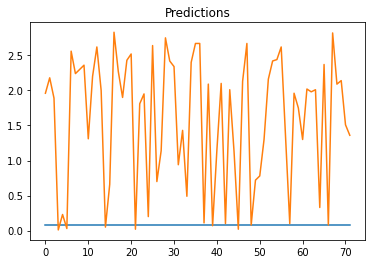

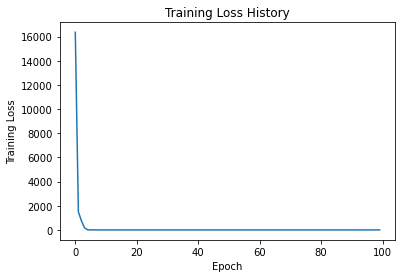

In [32]:
model = Sequential()
model.add(InputLayer(input_shape))
model.add(Conv1D(64, kernel_size=2))
model.add(Flatten())
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))


mname = f"epochs{epochs}/cnn"
cp = ModelCheckpoint(mname, save_best_only=True)

model, history = fit_model(model, cp, epochs, x_train, y_train, x_val, y_val)
cnn_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "cnn")

In [33]:
cnn_mse

3.1205476028116617

### GRU

INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


3/3 [==============================] - 0s 6ms/step


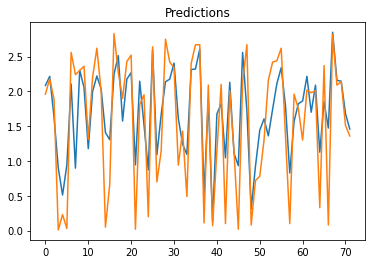

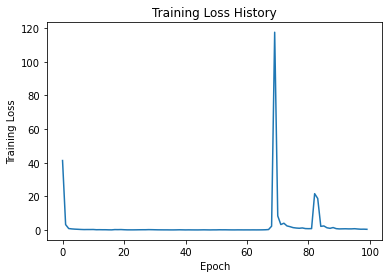

In [34]:
model = keras.Sequential([
    layers.GRU(units=64, activation="relu", return_sequences=True, input_shape=input_shape),
#    layers.Dropout(0.2), 
    layers.GRU(units=32, activation="relu"),
#    layers.Dropout(0.1),
    layers.Dense(1) 
  ])

mname = f"epochs{epochs}/gru"
cp = ModelCheckpoint(mname, save_best_only=True)

model, history = fit_model(model, cp, epochs, x_train, y_train, x_val, y_val)
gru_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "gru")

In [35]:
gru_mse

0.27738493469944153

INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


INFO:tensorflow:Assets written to: epochs100/gru/assets


3/3 [==============================] - 1s 6ms/step


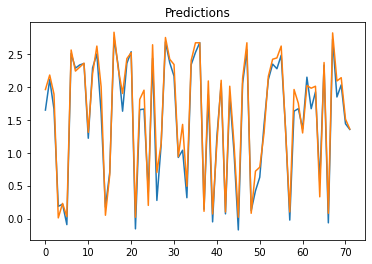

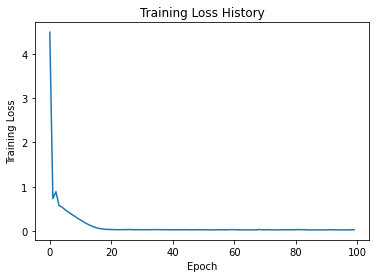

In [36]:
model = keras.Sequential([
    layers.GRU(units=64, input_shape=input_shape),
    layers.Dense(units=1)
])

model.compile(loss='mean_squared_error', optimizer='adam')

mname = f"epochs{epochs}/gru"
cp = ModelCheckpoint(mname, save_best_only=True)

model, history = fit_model(model, cp, epochs, x_train, y_train, x_val, y_val)
gru_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "gru")

In [37]:
gru_mse

0.02646248727930324

### LSTM

INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


INFO:tensorflow:Assets written to: epochs100/lstm/assets


3/3 [==============================] - 0s 6ms/step


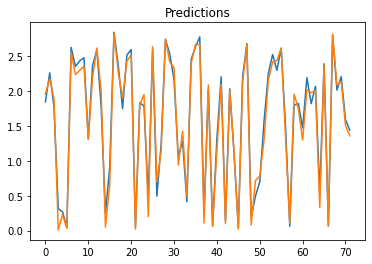

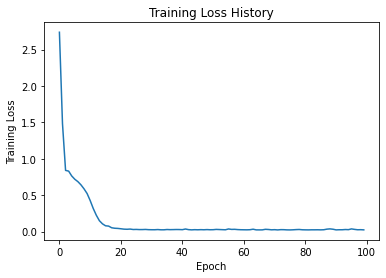

In [38]:
model = Sequential()
model.add(InputLayer(input_shape))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

mname = f"epochs{epochs}/lstm"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, x_train, y_train, x_val, y_val)

lstm_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "lstm")

### RNN

INFO:tensorflow:Assets written to: epochs100/rnn/assets


INFO:tensorflow:Assets written to: epochs100/rnn/assets


INFO:tensorflow:Assets written to: epochs100/rnn/assets


INFO:tensorflow:Assets written to: epochs100/rnn/assets


INFO:tensorflow:Assets written to: epochs100/rnn/assets


INFO:tensorflow:Assets written to: epochs100/rnn/assets


INFO:tensorflow:Assets written to: epochs100/rnn/assets


INFO:tensorflow:Assets written to: epochs100/rnn/assets


INFO:tensorflow:Assets written to: epochs100/rnn/assets


INFO:tensorflow:Assets written to: epochs100/rnn/assets


INFO:tensorflow:Assets written to: epochs100/rnn/assets


INFO:tensorflow:Assets written to: epochs100/rnn/assets


INFO:tensorflow:Assets written to: epochs100/rnn/assets


INFO:tensorflow:Assets written to: epochs100/rnn/assets


INFO:tensorflow:Assets written to: epochs100/rnn/assets


INFO:tensorflow:Assets written to: epochs100/rnn/assets


INFO:tensorflow:Assets written to: epochs100/rnn/assets


INFO:tensorflow:Assets written to: epochs100/rnn/assets


INFO:tensorflow:Assets written to: epochs100/rnn/assets


INFO:tensorflow:Assets written to: epochs100/rnn/assets


INFO:tensorflow:Assets written to: epochs100/rnn/assets


INFO:tensorflow:Assets written to: epochs100/rnn/assets


INFO:tensorflow:Assets written to: epochs100/rnn/assets


INFO:tensorflow:Assets written to: epochs100/rnn/assets


INFO:tensorflow:Assets written to: epochs100/rnn/assets


INFO:tensorflow:Assets written to: epochs100/rnn/assets


INFO:tensorflow:Assets written to: epochs100/rnn/assets


INFO:tensorflow:Assets written to: epochs100/rnn/assets


INFO:tensorflow:Assets written to: epochs100/rnn/assets


INFO:tensorflow:Assets written to: epochs100/rnn/assets


INFO:tensorflow:Assets written to: epochs100/rnn/assets


INFO:tensorflow:Assets written to: epochs100/rnn/assets


INFO:tensorflow:Assets written to: epochs100/rnn/assets


INFO:tensorflow:Assets written to: epochs100/rnn/assets


INFO:tensorflow:Assets written to: epochs100/rnn/assets


INFO:tensorflow:Assets written to: epochs100/rnn/assets


INFO:tensorflow:Assets written to: epochs100/rnn/assets


INFO:tensorflow:Assets written to: epochs100/rnn/assets


3/3 [==============================] - 0s 4ms/step


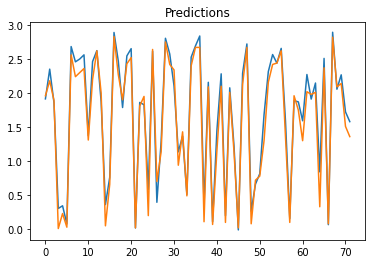

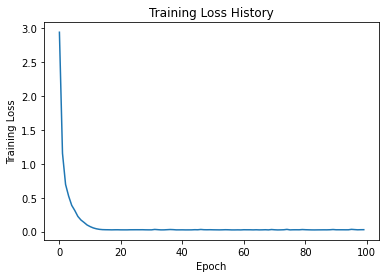

In [39]:
model = keras.Sequential([
    layers.SimpleRNN(units=64, input_shape=input_shape),
    layers.Dense(units=1)
])

model.compile(loss='mean_squared_error', optimizer='adam')

mname = f"epochs{epochs}/rnn"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, x_train, y_train, x_val, y_val)

rnn_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "rnn")

# Moving Average

In [40]:
window_size = 5

def moving_average(data, window_size):
    cumsum = np.cumsum(data, axis=0)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

moving_avg_data = np.apply_along_axis(lambda x: moving_average(x, window_size), axis=0, arr=x_train)
target = y_train[window_size - 1:].flatten()

#### CNN

INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_cnn/assets


3/3 [==============================] - 0s 2ms/step


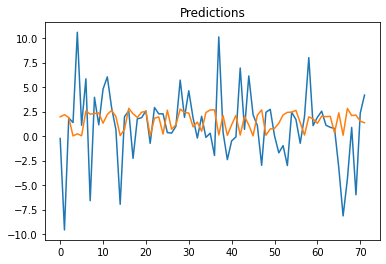

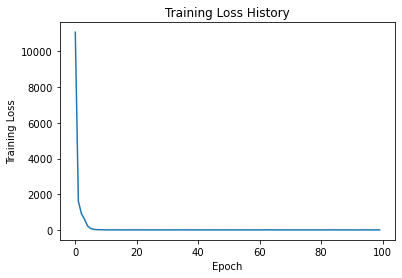

In [41]:
model = keras.Sequential([
    layers.Conv1D(filters=32, kernel_size=3, activation="relu", input_shape=input_shape),  # Adjust filter size as needed
    layers.MaxPool1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(16, activation="relu"),
    layers.Dense(1)  # Output layer with 1 unit for forecasting
  ])

mname = f"epochs{epochs}/mavg_cnn"
cp = ModelCheckpoint(mname, save_best_only=True)

model, history = fit_model(model, cp, epochs, moving_avg_data, target,x_val, y_val)

mvg_cnn_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "mavg_cnn")

In [42]:
mvg_cnn_mse

14.948664943357683

model = Sequential()
model.add(InputLayer(input_shape))
model.add(Conv1D(64, kernel_size=2))
model.add(Flatten())
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

cp = ModelCheckpoint('mavg_cnn/', save_best_only=True)

model, history = fit_model(model, cp, epochs, moving_avg_data, target,x_val, y_val)

mvg_cnn_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "mavg_cnn")

mvg_cnn_mse

#### GRU

INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_gru/assets


3/3 [==============================] - 0s 7ms/step


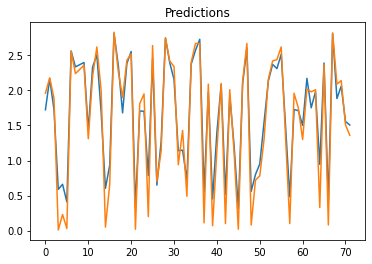

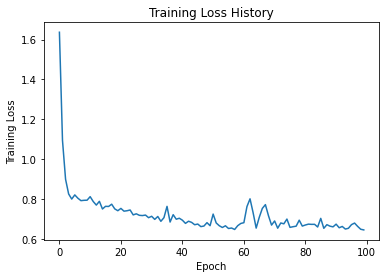

In [43]:
model = keras.Sequential([
    layers.GRU(units=64, input_shape=input_shape),
    layers.Dense(units=1)
])

model.compile(loss='mean_squared_error', optimizer='adam')

mname = f"epochs{epochs}/mavg_gru"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs,  moving_avg_data, target, x_val, y_val)

mvg_gru_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "mavg_gru")

#### LSTM

INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_lstm/assets


3/3 [==============================] - 2s 8ms/step


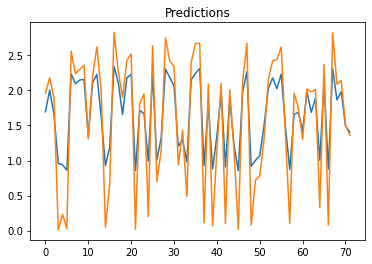

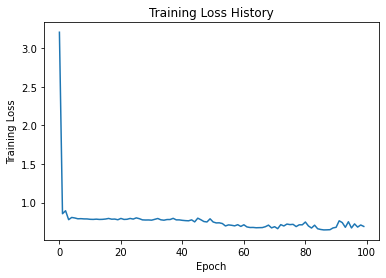

In [44]:
model = keras.Sequential([
  keras.layers.LSTM(units=64, return_sequences=True, input_shape=(input_shape)),  # First LSTM layer
  keras.layers.LSTM(units=32),  # Second LSTM layer
  keras.layers.Dense(units=1)  # Output layer with 1 unit for single-value prediction
])

'''
model = Sequential()
model.add(InputLayer(input_shape))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))
'''
mname = f"epochs{epochs}/mavg_lstm"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, moving_avg_data, target, x_val, y_val)

mvg_lstm_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "mavg_lstm")

#### RNN

INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_rnn/assets


3/3 [==============================] - 0s 4ms/step


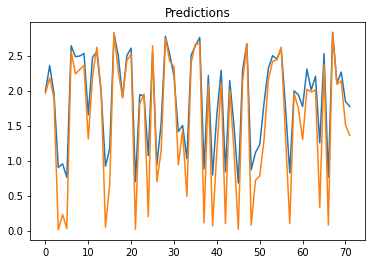

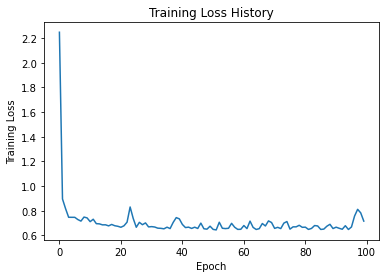

In [45]:
model = keras.Sequential([
    layers.SimpleRNN(units=64, input_shape=input_shape),
    layers.Dense(units=1)
])

model.compile(loss='mean_squared_error', optimizer='adam')

mname = f"epochs{epochs}/mavg_rnn"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, moving_avg_data, target, x_val, y_val)

mvg_rnn_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "mavg_rnn")

# AutoEncoder

### CNN

INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


INFO:tensorflow:Assets written to: epochs100/autoencoder_cnn/assets


3/3 [==============================] - 0s 3ms/step


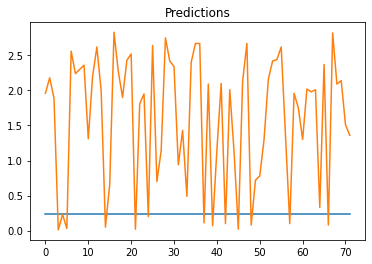

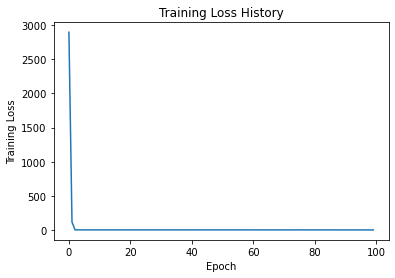

In [46]:
model = Sequential()
model.add(InputLayer(input_shape))
model.add(Conv1D(64, kernel_size=2))
model.add(Dropout(0.2))
model.add(Conv1D(64, kernel_size=1))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))


model.compile(loss='mean_squared_error', optimizer='adam')

mname = f"epochs{epochs}/autoencoder_cnn"
cp = ModelCheckpoint(mname, save_best_only=True)

model, history = fit_model(model, cp, epochs, x_train, y_train, x_val, y_val)

auto_cnn_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "auto_cnn")

In [47]:
auto_cnn_mse

2.671348274524178

### GRU

INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/auto_gru/assets


3/3 [==============================] - 0s 5ms/step


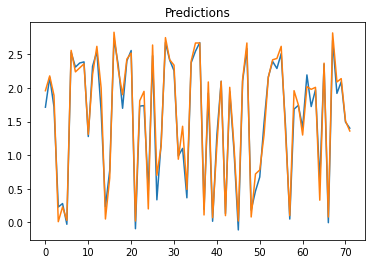

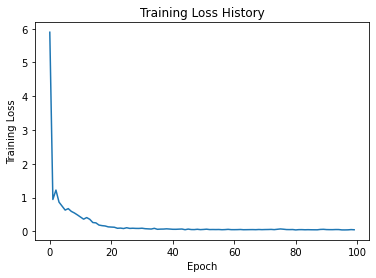

In [48]:
model = Sequential()
model.add(InputLayer(input_shape))
model.add(GRU(64))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1))


model.compile(loss='mean_squared_error', optimizer='adam')

mname = f"epochs{epochs}/auto_gru"
cp = ModelCheckpoint(mname, save_best_only=True)

model, history = fit_model(model, cp, epochs, x_train, y_train, x_val, y_val)

auto_gru_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "auto_gru")

In [49]:
auto_gru_mse

0.019757352388452616

### LSTM

INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/auto_lstm/assets


3/3 [==============================] - 1s 9ms/step


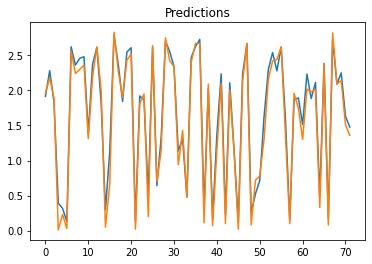

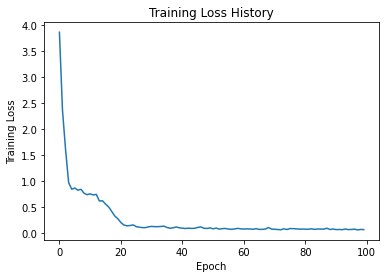

In [50]:
model = Sequential()
model.add(InputLayer(input_shape))
model.add(LSTM(64))
model.add(Dropout(0.3))
#model.add(RepeatVector(3))
#model.add(LSTM(64, return_sequences=True))
#model.add(Dropout(0.4))
model.add(Dense(8, 'relu'))
model.add(Flatten())
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

mname = f"epochs{epochs}/auto_lstm"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, x_train, y_train, x_val, y_val)


auto_lstm_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "auto_lstm")

In [51]:
auto_lstm_mse

0.02135425702964399

### RNN

INFO:tensorflow:Assets written to: epochs100/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/auto_rnn/assets


3/3 [==============================] - 0s 4ms/step


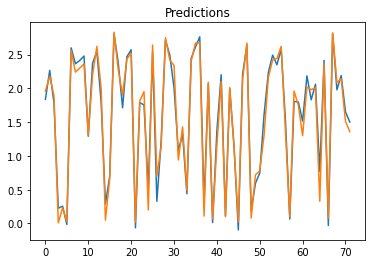

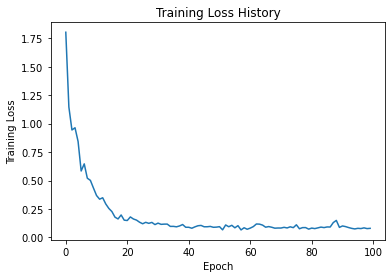

In [52]:
model = Sequential()
model.add(InputLayer(input_shape))
model.add(SimpleRNN(64))
model.add(Dropout(0.4))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

mname = f"epochs{epochs}/auto_rnn"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, x_train, y_train, x_val, y_val)


auto_rnn_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "auto_rnn")

In [53]:
auto_rnn_mse

0.020091867011623753

# Moving Average with Encoder

### CNN

INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_cnn/assets


3/3 [==============================] - 0s 3ms/step


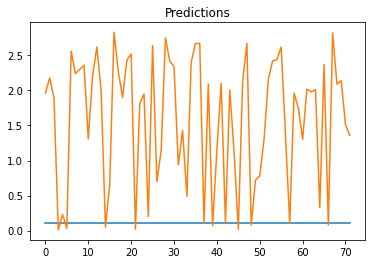

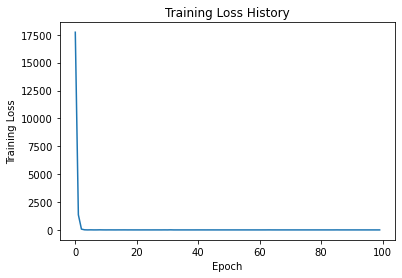

In [54]:
model = Sequential()
model.add(InputLayer(input_shape))
model.add(Conv1D(64, kernel_size=2))
model.add(Dropout(0.2))
model.add(Conv1D(64, kernel_size=1))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))


model.compile(loss='mean_squared_error', optimizer='adam')
mname = f"epochs{epochs}/mavg_auto_cnn"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, moving_avg_data, target, x_val, y_val)

mavg_auto_cnn_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "mavg_auto_cnn")

In [55]:
mavg_auto_cnn_mse

3.0443347748654994

### RNN

INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_rnn/assets


3/3 [==============================] - 0s 4ms/step


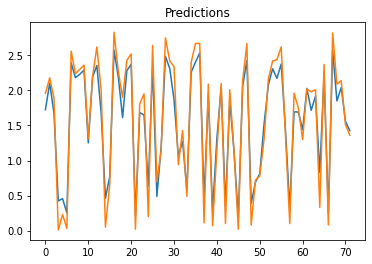

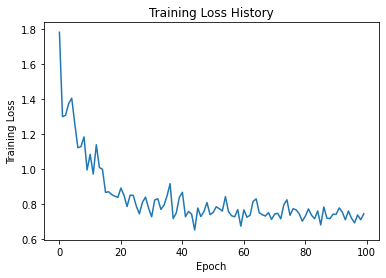

In [56]:
model = Sequential()
model.add(InputLayer(input_shape))
model.add(SimpleRNN(64))
model.add(Dropout(0.4))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

mname = f"epochs{epochs}/mavg_auto_rnn"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs,moving_avg_data,target, x_val, y_val)

mavg_auto_rnn_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "mavg_auto_rnn")

In [57]:
mavg_auto_rnn_mse

0.044949952790081925

### GRU

INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_gru/assets


3/3 [==============================] - 1s 9ms/step


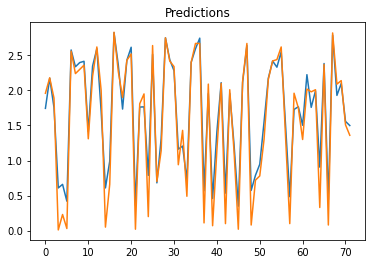

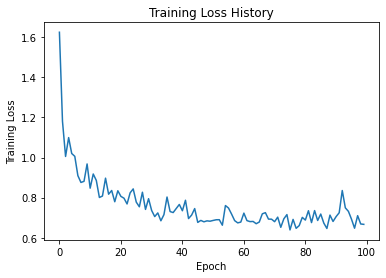

In [58]:
model = Sequential()
model.add(InputLayer(input_shape))
model.add(GRU(64))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
mname = f"epochs{epochs}/mavg_auto_gru"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, moving_avg_data, target, x_val, y_val)

mavg_auto_gru_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "mavg_auto_gru")

In [59]:
mavg_auto_gru_mse

0.05646435584542574

### LSTM

INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_auto_lstm/assets


3/3 [==============================] - 1s 7ms/step


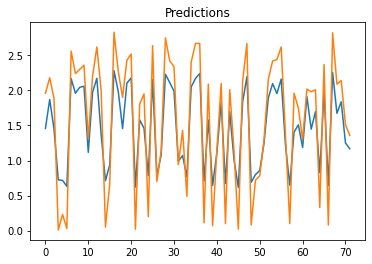

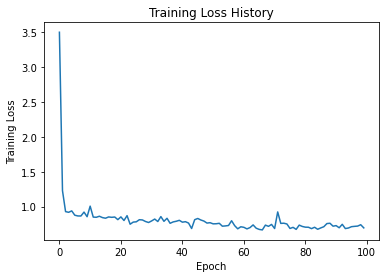

In [60]:
model = Sequential()
model.add(InputLayer(input_shape))
model.add(LSTM(64))
model.add(Dropout(0.3))
#model.add(RepeatVector(3))
#model.add(LSTM(64, return_sequences=True))
#model.add(Dropout(0.4))
#model.add(Dense(8, 'relu'))
#model.add(Flatten())
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

mname = f"epochs{epochs}/mavg_auto_lstm"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs,moving_avg_data, target, x_val, y_val)

mavg_auto_lstm_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "mavg_auto_lstm")

In [61]:
mavg_auto_lstm_mse

0.16894640889703194

# Hybrid

## General

### CNN LSTM

INFO:tensorflow:Assets written to: epochs100/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_cnn_lstm/assets


3/3 [==============================] - 1s 8ms/step


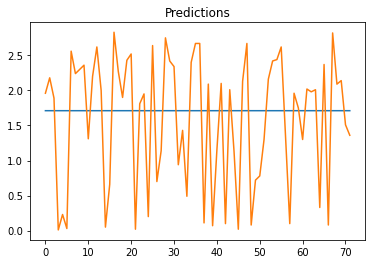

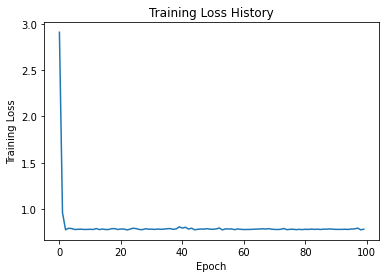

In [62]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(RepeatVector(n=input_shape[0]))
model.add(LSTM(units=64, return_sequences=True))
model.add(LSTM(units=32))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
mname = f"epochs{epochs}/hybrid_cnn_lstm"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, x_train,y_train, x_val, y_val)

hybrid_cnn_lstm_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "hybrid_cnn_lstm")

In [63]:
hybrid_cnn_lstm_mse

0.851768689513178

### RNN LSTM

INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_lstm/assets


3/3 [==============================] - 1s 11ms/step


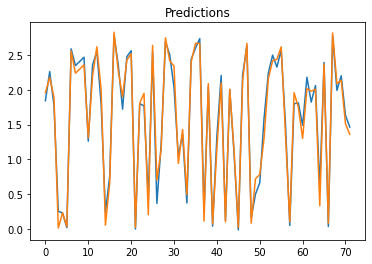

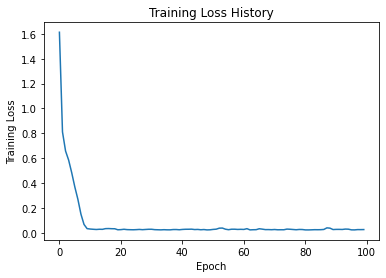

In [64]:
model = Sequential()
model.add(SimpleRNN(64,return_sequences=True, input_shape=input_shape))
model.add(LSTM(32))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
mname = f"epochs{epochs}/hybrid_rnn_lstm"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, x_train,y_train, x_val, y_val)

hybrid_rnn_lstm_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "hybrid_rnn_lstm")

In [65]:
hybrid_rnn_lstm_mse

0.01610758103384687

### RNN GRU

INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_rnn_gru/assets


3/3 [==============================] - 0s 7ms/step


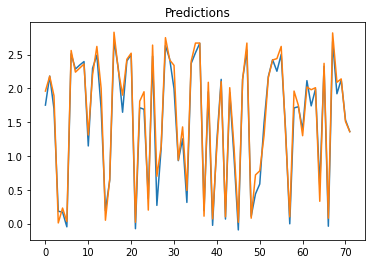

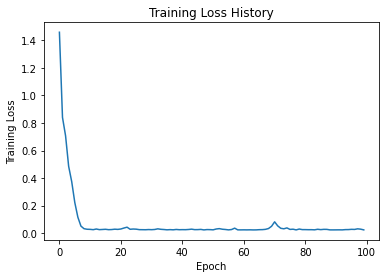

In [66]:
model = Sequential()
model.add(SimpleRNN(64, return_sequences=True, input_shape=input_shape))
model.add(GRU(32))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
mname = f"epochs{epochs}/hybrid_rnn_gru"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, x_train,y_train, x_val, y_val)

hybrid_rnn_gru_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "hybrid_rnn_gru")

In [67]:
hybrid_rnn_gru_mse

0.020436810395225286

### CNN GRU

INFO:tensorflow:Assets written to: epochs100/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_cnn_gru/assets


3/3 [==============================] - 1s 11ms/step


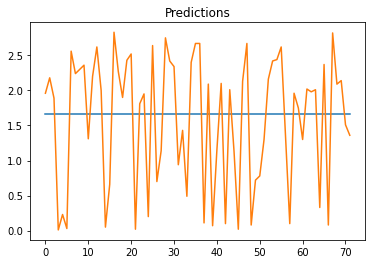

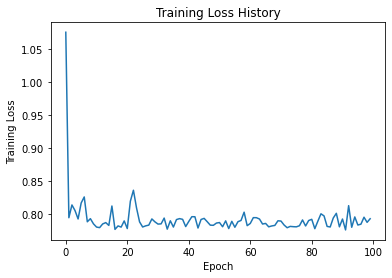

In [68]:
model = Sequential()

model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Flatten())

model.add(RepeatVector(n=15))
model.add(GRU(64, return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
mname = f"epochs{epochs}/hybrid_cnn_gru"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, x_train,y_train, x_val, y_val)

hybrid_cnn_gru_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "hybrid_cnn_gru")

In [69]:
hybrid_cnn_gru_mse

0.8421140611793846

### CNN RNN GRU

INFO:tensorflow:Assets written to: epochs100/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_cnn_rnn_gru/assets


3/3 [==============================] - 1s 8ms/step


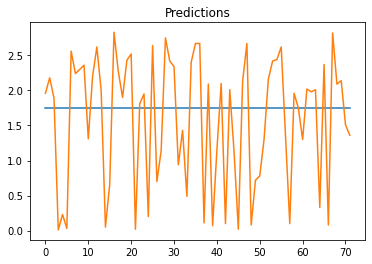

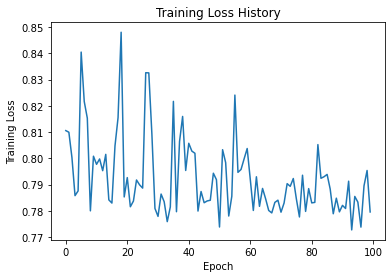

In [70]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Flatten())
model.add(RepeatVector(n=15))
model.add(SimpleRNN(64, return_sequences=True))
model.add(GRU(32))
model.add(Dense(8))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
mname = f"epochs{epochs}/hybrid_cnn_rnn_gru"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, x_train,y_train, x_val, y_val)

hybrid_cnn_rnn_gru_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "hybrid_cnn_rnn_gru")

In [71]:
hybrid_cnn_rnn_gru_mse

0.8613122942240974

### LSTM RNN GRU

INFO:tensorflow:Assets written to: epochs100/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/hybrid_lstm_rnn_gru/assets


3/3 [==============================] - 1s 13ms/step


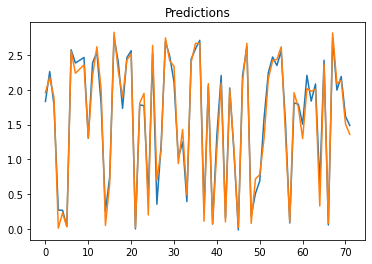

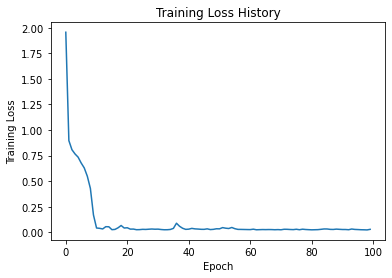

In [72]:
model = Sequential()
model.add(SimpleRNN(64, return_sequences=True, input_shape=input_shape))
model.add(LSTM(128, return_sequences=True))
model.add(GRU(64))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
mname = f"epochs{epochs}/hybrid_lstm_rnn_gru"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history =fit_model(model, cp, epochs, x_train,y_train, x_val, y_val)

hybrid_lstm_rnn_gru_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "hybrid_lstm_rnn_gru")

In [73]:
hybrid_lstm_rnn_gru_mse

0.01721419981935117

## Moving Average

### CNN LSTM

INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_lstm/assets


3/3 [==============================] - 1s 8ms/step


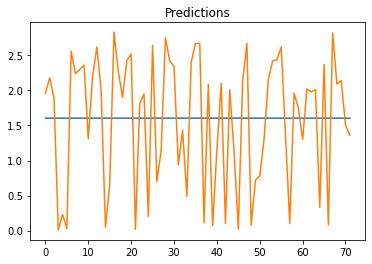

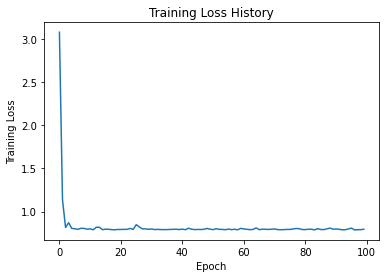

In [74]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(RepeatVector(n=input_shape[0]))
model.add(LSTM(units=64, return_sequences=True))
model.add(LSTM(units=32))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

mname = f"epochs{epochs}/mavg_hybrid_cnn_lstm"
cp = ModelCheckpoint(mname, save_best_only=True)

model, history = fit_model(model, cp, epochs, moving_avg_data, target, x_val, y_val)

mavg_hybrid_cnn_lstm_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "mavg_hybrid_cnn_lstm")

In [75]:
mavg_hybrid_cnn_lstm_mse

0.8371392630235256

### RNN LSTM

INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_lstm/assets


3/3 [==============================] - 1s 6ms/step


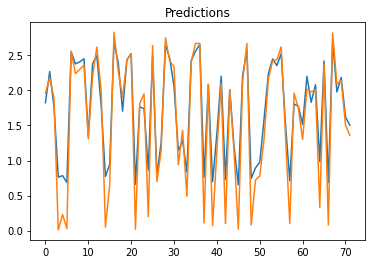

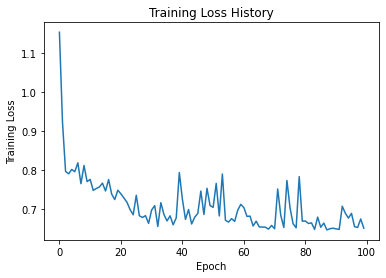

In [76]:
model = Sequential()
model.add(SimpleRNN(64,return_sequences=True, input_shape=input_shape))
model.add(LSTM(32))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
mname = f"epochs{epochs}/mavg_hybrid_rnn_lstm"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, moving_avg_data, target, x_val, y_val)

mavg_hybrid_rnn_lstm_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "mavg_hybrid_rnn_lstm")

In [77]:
mavg_hybrid_rnn_lstm_mse

0.09842288976857436

### RNN GRU

INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_rnn_gru/assets


3/3 [==============================] - 1s 9ms/step


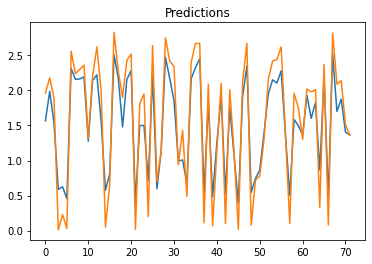

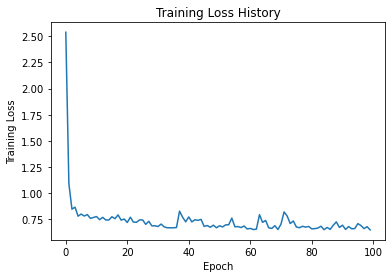

In [78]:
model = Sequential()
model.add(SimpleRNN(64, return_sequences=True, input_shape=input_shape))
model.add(GRU(32))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
mname = f"epochs{epochs}/mavg_hybrid_rnn_gru"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, moving_avg_data, target, x_val, y_val)

mavg_hybrid_rnn_gru_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "mavg_hybrid_rnn_gru")

In [79]:
mavg_hybrid_rnn_gru_mse

0.0950042544255765

### CNN GRU

INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_gru/assets


3/3 [==============================] - 1s 9ms/step


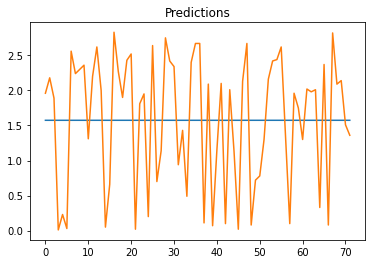

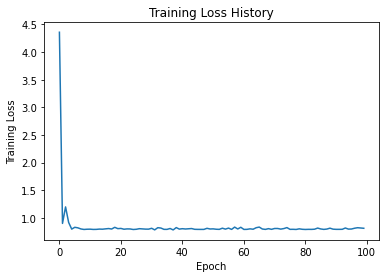

In [80]:
model = Sequential()

model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
#model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())

model.add(RepeatVector(n=15))
model.add(GRU(64, return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
mname = f"epochs{epochs}/mavg_hybrid_cnn_gru"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, moving_avg_data, target, x_val, y_val)

mavg_hybrid_cnn_gru_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "mavg_hybrid_cnn_gru")

In [81]:
mavg_hybrid_cnn_gru_mse

0.8371152895254507

### CNN RNN GRU

INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_cnn_rnn_gru/assets


3/3 [==============================] - 1s 8ms/step


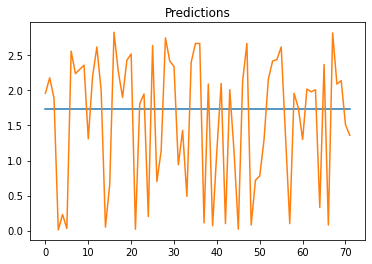

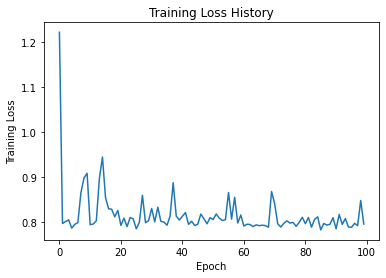

In [82]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
#model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(RepeatVector(n=15))
model.add(SimpleRNN(64, return_sequences=True))
model.add(GRU(32))
model.add(Dense(8))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
mname = f"epochs{epochs}/mavg_hybrid_cnn_rnn_gru"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, moving_avg_data, target, x_val, y_val)

mavg_hybrid_cnn_rnn_gru_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "mavg_hybrid_cnn_rnn_gru")

In [83]:
mavg_hybrid_cnn_rnn_gru_mse

0.8580090125636167

### RNN LSTM GRU

INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


INFO:tensorflow:Assets written to: epochs100/mavg_hybrid_lstm_rnn_gru/assets


3/3 [==============================] - 1s 16ms/step


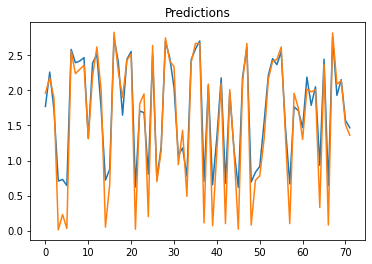

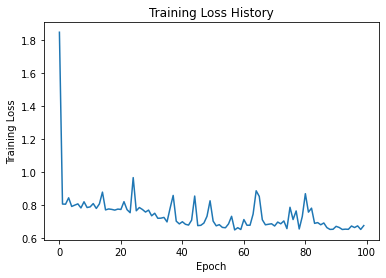

In [84]:
model = Sequential()
model.add(SimpleRNN(64, return_sequences=True, input_shape=input_shape))
model.add(LSTM(128, return_sequences=True))
model.add(GRU(64))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
mname = f"epochs{epochs}/mavg_hybrid_lstm_rnn_gru"
cp = ModelCheckpoint(mname, save_best_only=True)
model, history = fit_model(model, cp, epochs, moving_avg_data, target,x_val, y_val)

mavg_hybrid_lstm_rnn_gru_mse = plot_predictions1(model,x_test, y_test)
plot_train_history(history)
save_history(history, "mavg_hybrid_lstm_rnn_gru")

In [85]:
mavg_hybrid_lstm_rnn_gru_mse

0.08530670395568711

# MSE

In [86]:
gen = ["General" for _ in range(0,4)]
ma = ["MA" for _ in range(0,4)]
ae = ["AE" for _ in range(0,4)]
ma_ae = ["MA AE" for _ in range(0,4)]
hy = ["HY" for _ in range(0,6)]
ma_hy = ["MA HY" for _ in range(0,6)]

In [87]:
model_cat = []

for a in gen:
    model_cat.append(a)
for a in ma:
    model_cat.append(a)
for a in ae:
    model_cat.append(a)
for a in ma_ae:
    model_cat.append(a)
for a in hy:
    model_cat.append(a)
for a in ma_hy:
    model_cat.append(a)

In [88]:
mse_list = [cnn_mse, rnn_mse, gru_mse, lstm_mse,
            mvg_cnn_mse, mvg_rnn_mse, mvg_gru_mse, mvg_lstm_mse,
            auto_cnn_mse, auto_rnn_mse, auto_gru_mse, auto_lstm_mse,
            mavg_auto_cnn_mse, mavg_auto_rnn_mse, mavg_auto_gru_mse, mavg_auto_lstm_mse,
            hybrid_cnn_lstm_mse, hybrid_lstm_rnn_gru_mse,hybrid_cnn_rnn_gru_mse,hybrid_cnn_gru_mse,
            hybrid_rnn_gru_mse,hybrid_rnn_lstm_mse,
            mavg_hybrid_cnn_lstm_mse, mavg_hybrid_lstm_rnn_gru_mse,mavg_hybrid_cnn_rnn_gru_mse,
            mavg_hybrid_cnn_gru_mse,mavg_hybrid_rnn_gru_mse,mavg_hybrid_rnn_lstm_mse]

model_n = ["CNN", "RNN", "GRU", "LSTM",
           "CNN", "RNN", "GRU", "LSTM",
           "CNN", "RNN", "GRU", "LSTM",
           "CNN", "RNN", "GRU", "LSTM",
           "HY CNN LSTM", "HY LSTM RNN GRU" ,"HY CNN RNN GRU","HY CNN GRU",
           "HY RNN GRU","HY RNN LSTM",
           "MA HY CNN LSTM", "MA HY LSTM RNN GRU","MA HY CNN RNN GRU",
           "MA HY CNN GRU","MA HY RNN GRU","MA HY RNN LSTM"
          ]

msedf = pd.DataFrame({
    "ModelCat": model_cat,
    "Model": model_n,
    "MSE": mse_list
})

rmse = np.sqrt(msedf.MSE)
msedf["RMSE"] = rmse

In [89]:
msedf

,ModelCat,Model,MSE,RMSE
0,General,CNN,3.120548,1.766507
1,General,RNN,0.029430,0.171553
2,General,GRU,0.026462,0.162673
3,General,LSTM,0.015711,0.125343
4,MA,CNN,14.948665,3.866350
5,MA,RNN,0.165610,0.406952
6,MA,GRU,0.056982,0.238708
7,MA,LSTM,0.189747,0.435599
8,AE,CNN,2.671348,1.634426
9,AE,RNN,0.020092,0.141746


In [90]:
msedf.to_csv("msedf.csv", index= False)

<AxesSubplot:xlabel='Model'>

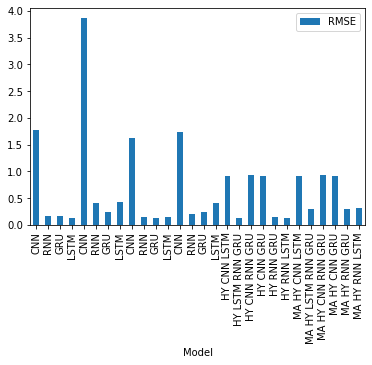

In [92]:
msedf.plot("Model", "RMSE", kind= "bar")

In [93]:
np.save(f"epochs{epochs}/x_train.npy", x_train)
np.save(f"epochs{epochs}/y_train.npy", y_train)
np.save(f"epochs{epochs}/x_test.npy", x_test)
np.save(f"epochs{epochs}/y_test.npy", y_test)
np.save(f"epochs{epochs}/x_val.npy", x_val)
np.save(f"epochs{epochs}/y_val.npy", y_val)